In [1]:
from tkinter import filedialog
from tkinter import Tk
import numpy as np
import pandas as pd
import umap
from sklearn.preprocessing import LabelEncoder
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KernelDensity
from scipy.spatial import ConvexHull, Delaunay
import shap
import xgboost as xgb
import alphashape

root = Tk()
root.withdraw()

# read data
csv_file_path = filedialog.askopenfilename(title="Select Test-Data file", filetypes=(("CSV files", "*.csv"), ("All files", "*.*")))
Setting_File_path = filedialog.askopenfilename(title="Select Setting-file", filetypes=(("Excel files", "*.xlsx"), ("All files", "*.*")))

# df define
df = pd.read_csv(csv_file_path)
df_setting = pd.read_excel(Setting_File_path)

feature_vars = df_setting.loc[df_setting['Analysis_List'].notna(), 'Analysis_List'].tolist()
target_variable = df_setting.loc[df_setting['Target_Variable'].notna(), 'Target_Variable'].values[0]

# mode check @ test-Data
mode_data = df["Mode"]
unique_modes = mode_data.drop_duplicates().tolist()
print("Unique Modes:", unique_modes)

# data define
target_mode = "2wfF4"
train_df = df[df['Mode'] != target_mode]
test_df = df[df['Mode'] == target_mode]

train_data = train_df[feature_vars]
test_data = test_df[feature_vars]
target_data = train_df[target_variable]

# meta_data
train_ID = train_df["meta_ID"]
test_ID = test_df["meta_ID"]


# Unique Modes: ['USHWY', 'JC08', 'LA4', 'US06', '2WFf3kai', '2wfF4', 'VHmn', '2FJ']

Unique Modes: ['USHWY', 'JC08', 'LA4', 'US06', '2WFf3kai', '2wfF4', 'VHmn', '2FJ']


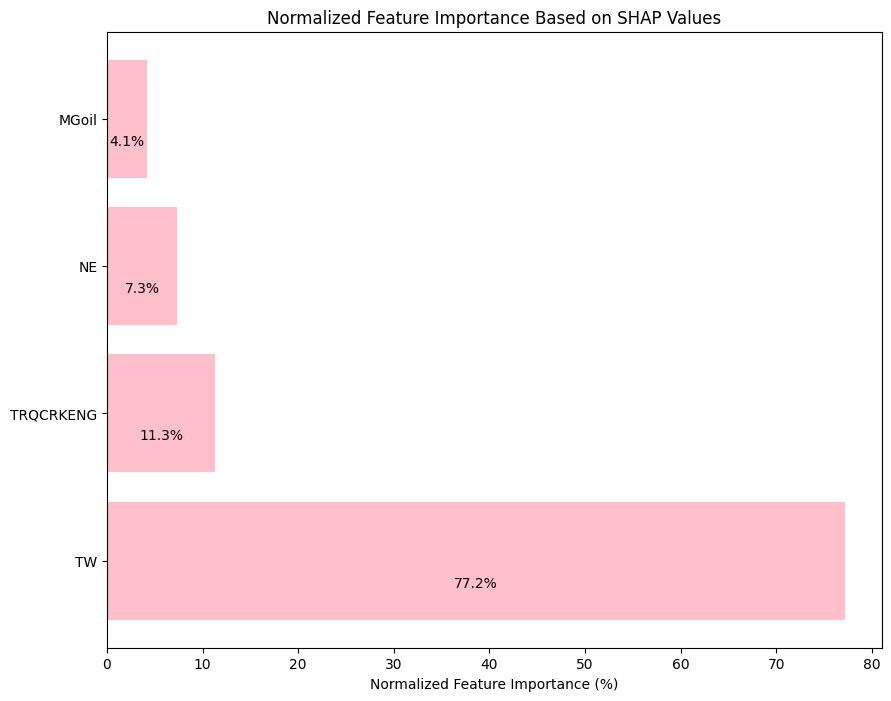

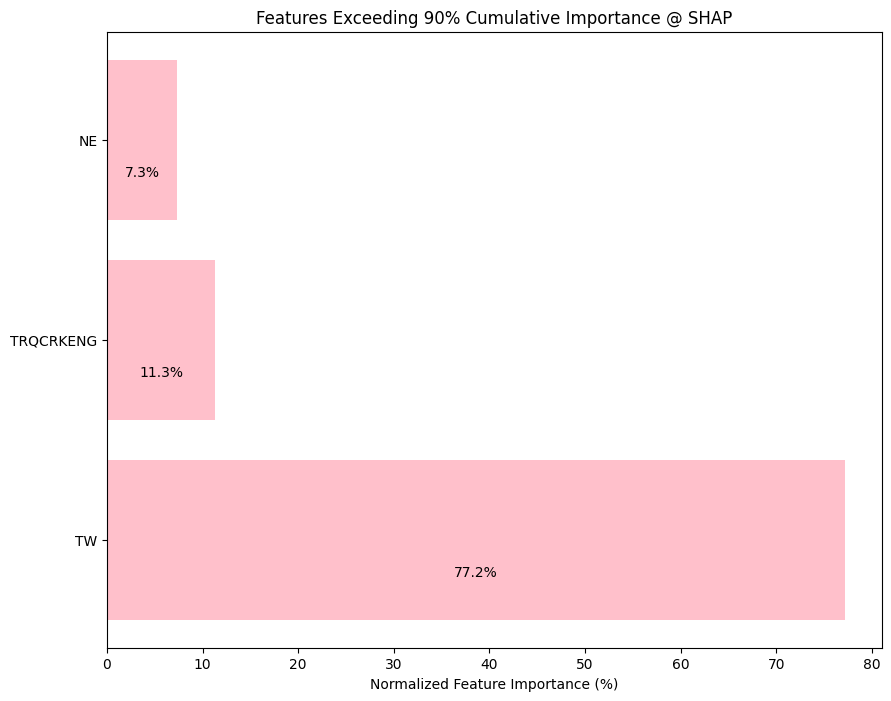

In [2]:
model = xgb.XGBRegressor(n_jobs=-1) 
model.fit(train_data, target_data) 

# SHAP
explainer = shap.Explainer(model)
shap_values = explainer(train_data)

# FI+sort
feature_importance = np.abs(shap_values.values).mean(axis=0)
sorted_idx = np.argsort(-feature_importance) 
sorted_importance = feature_importance[sorted_idx]

# Normalize
normalized_importance = (sorted_importance / np.sum(sorted_importance)) * 100

# plot
plt.figure(figsize=(10, 8))
bars = plt.barh(range(len(sorted_idx)), normalized_importance, align='center', color='pink') 
plt.yticks(range(len(sorted_idx)), [feature_vars[i] for i in sorted_idx]) 
plt.xlabel('Normalized Feature Importance (%)')
plt.title('Normalized Feature Importance Based on SHAP Values')

for bar in bars:
    plt.gca().text(bar.get_width() * 0.5, bar.get_y() + bar.get_height()/4,
                   f"{bar.get_width():.1f}%", color="black", fontsize=10, ha='center', va='bottom')

plt.show()

# 累計寄与度90%超えまでの特徴量を選択
cumulative_importance = np.cumsum(sorted_importance / np.sum(sorted_importance))
selected_features_idx = np.where(cumulative_importance > 0.9)[0][0] 
selected_features = [feature_vars[sorted_idx[i]] for i in range(selected_features_idx + 1)] 
selected_normalized_importance = normalized_importance[:selected_features_idx + 1]

# 可視化
plt.figure(figsize=(10, 8))
bars = plt.barh(range(len(selected_features)), selected_normalized_importance, align='center', color='pink')
plt.yticks(range(len(selected_features)), [feature_vars[sorted_idx[i]] for i in range(selected_features_idx + 1)])
plt.xlabel('Normalized Feature Importance (%)')
plt.title('Features Exceeding 90% Cumulative Importance @ SHAP')

# Add %
for bar in bars:
    plt.gca().text(bar.get_width() * 0.5, bar.get_y() + bar.get_height()/4,
                   f"{bar.get_width():.1f}%", color="black", fontsize=10, ha='center', va='bottom')

plt.show()


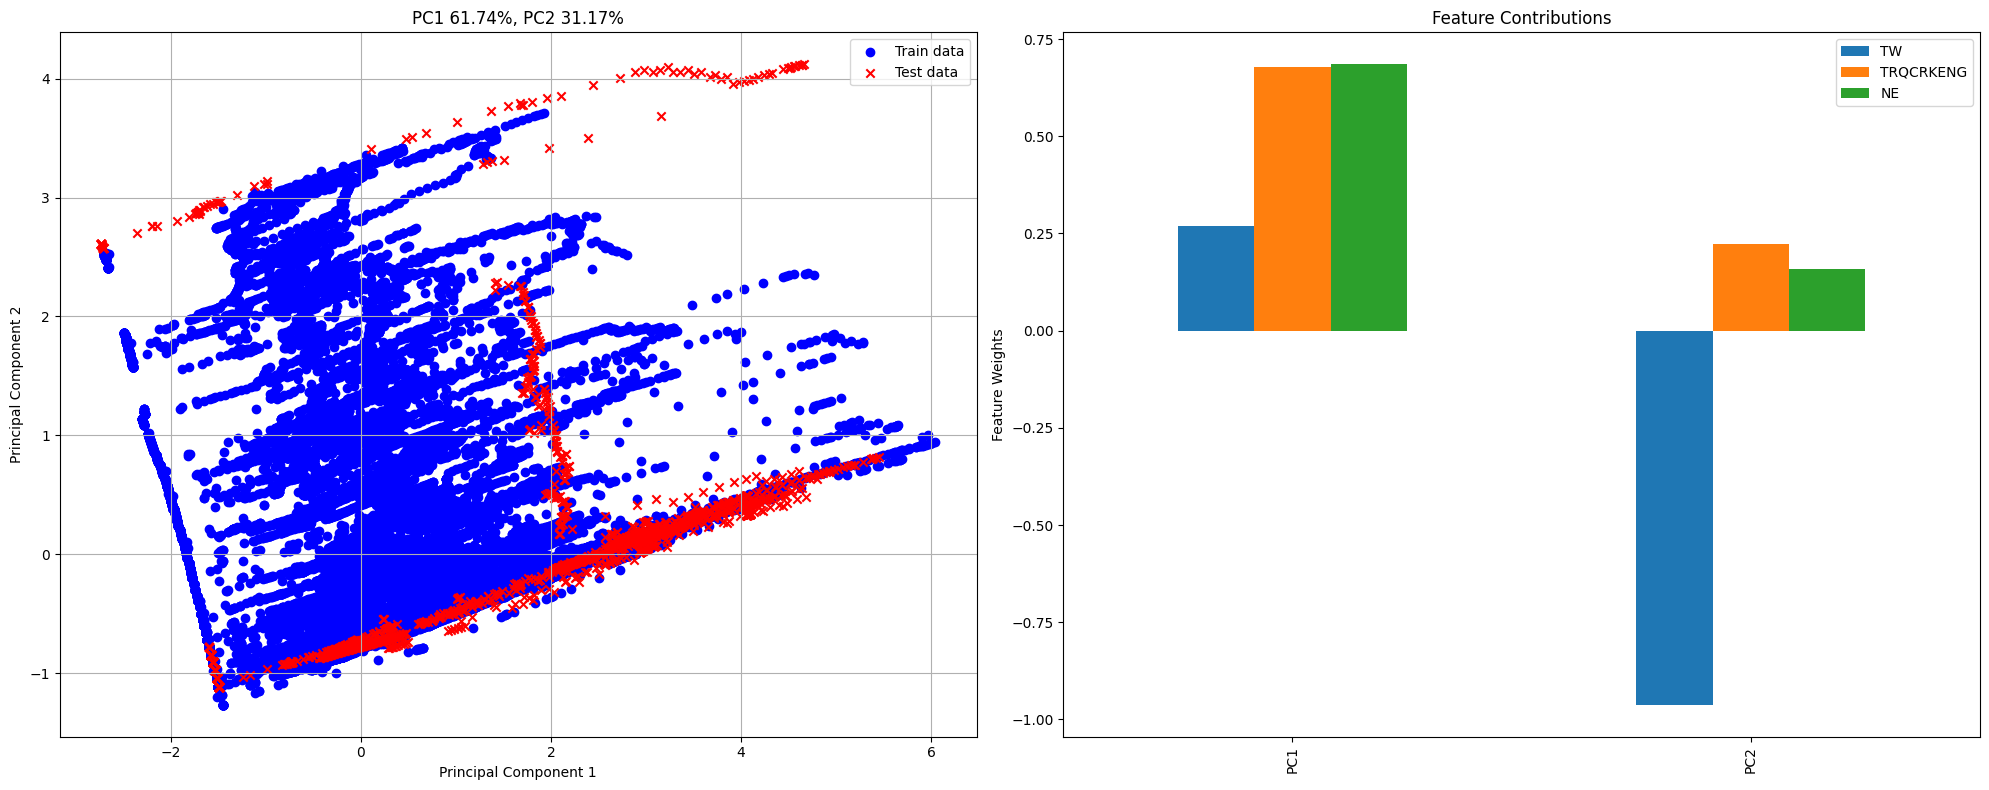

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

scaler = StandardScaler()
selected_train_data = scaler.fit_transform(train_data[selected_features])
selected_test_data = scaler.transform(test_data[selected_features])

# PCA
pca = PCA(n_components=0.9)
pca_train_data = pca.fit_transform(selected_train_data)
pca_test_data = pca.transform(selected_test_data)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Visualize PCA
ax = axes[0]
ax.scatter(pca_train_data[:, 0], pca_train_data[:, 1], c='blue', marker='o', label='Train data')
ax.scatter(pca_test_data[:, 0], pca_test_data[:, 1], c='red', marker='x', label='Test data') 
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')

# 分散寄与度計算
explained_variance_ratio = pca.explained_variance_ratio_
explained_variance_ratio1 = explained_variance_ratio[0] * 100
explained_variance_ratio2 = explained_variance_ratio[1] * 100

ax.set_title(f'PC1 {explained_variance_ratio1:.2f}%, PC2 {explained_variance_ratio2:.2f}%')
ax.legend(loc='upper right')
ax.grid(True)

# feature contribution
components_df = pd.DataFrame(pca.components_, columns=selected_features, index=[f'PC{i+1}' for i in range(len(pca.components_))])

# Visualize
ax = axes[1]
components_df.iloc[:2, :].plot(kind='bar', ax=ax)
ax.set_title('Feature Contributions')
ax.set_ylabel('Feature Weights')

plt.tight_layout()
plt.show()


For alpha=0, number of outsider_test_indices: 115
For alpha=0, number of boundary_train_indices: 199
For alpha=1, number of outsider_test_indices: 637
For alpha=1, number of boundary_train_indices: 2758
For alpha=2, number of outsider_test_indices: 643
For alpha=2, number of boundary_train_indices: 3345
For alpha=3, number of outsider_test_indices: 649
For alpha=3, number of boundary_train_indices: 3498


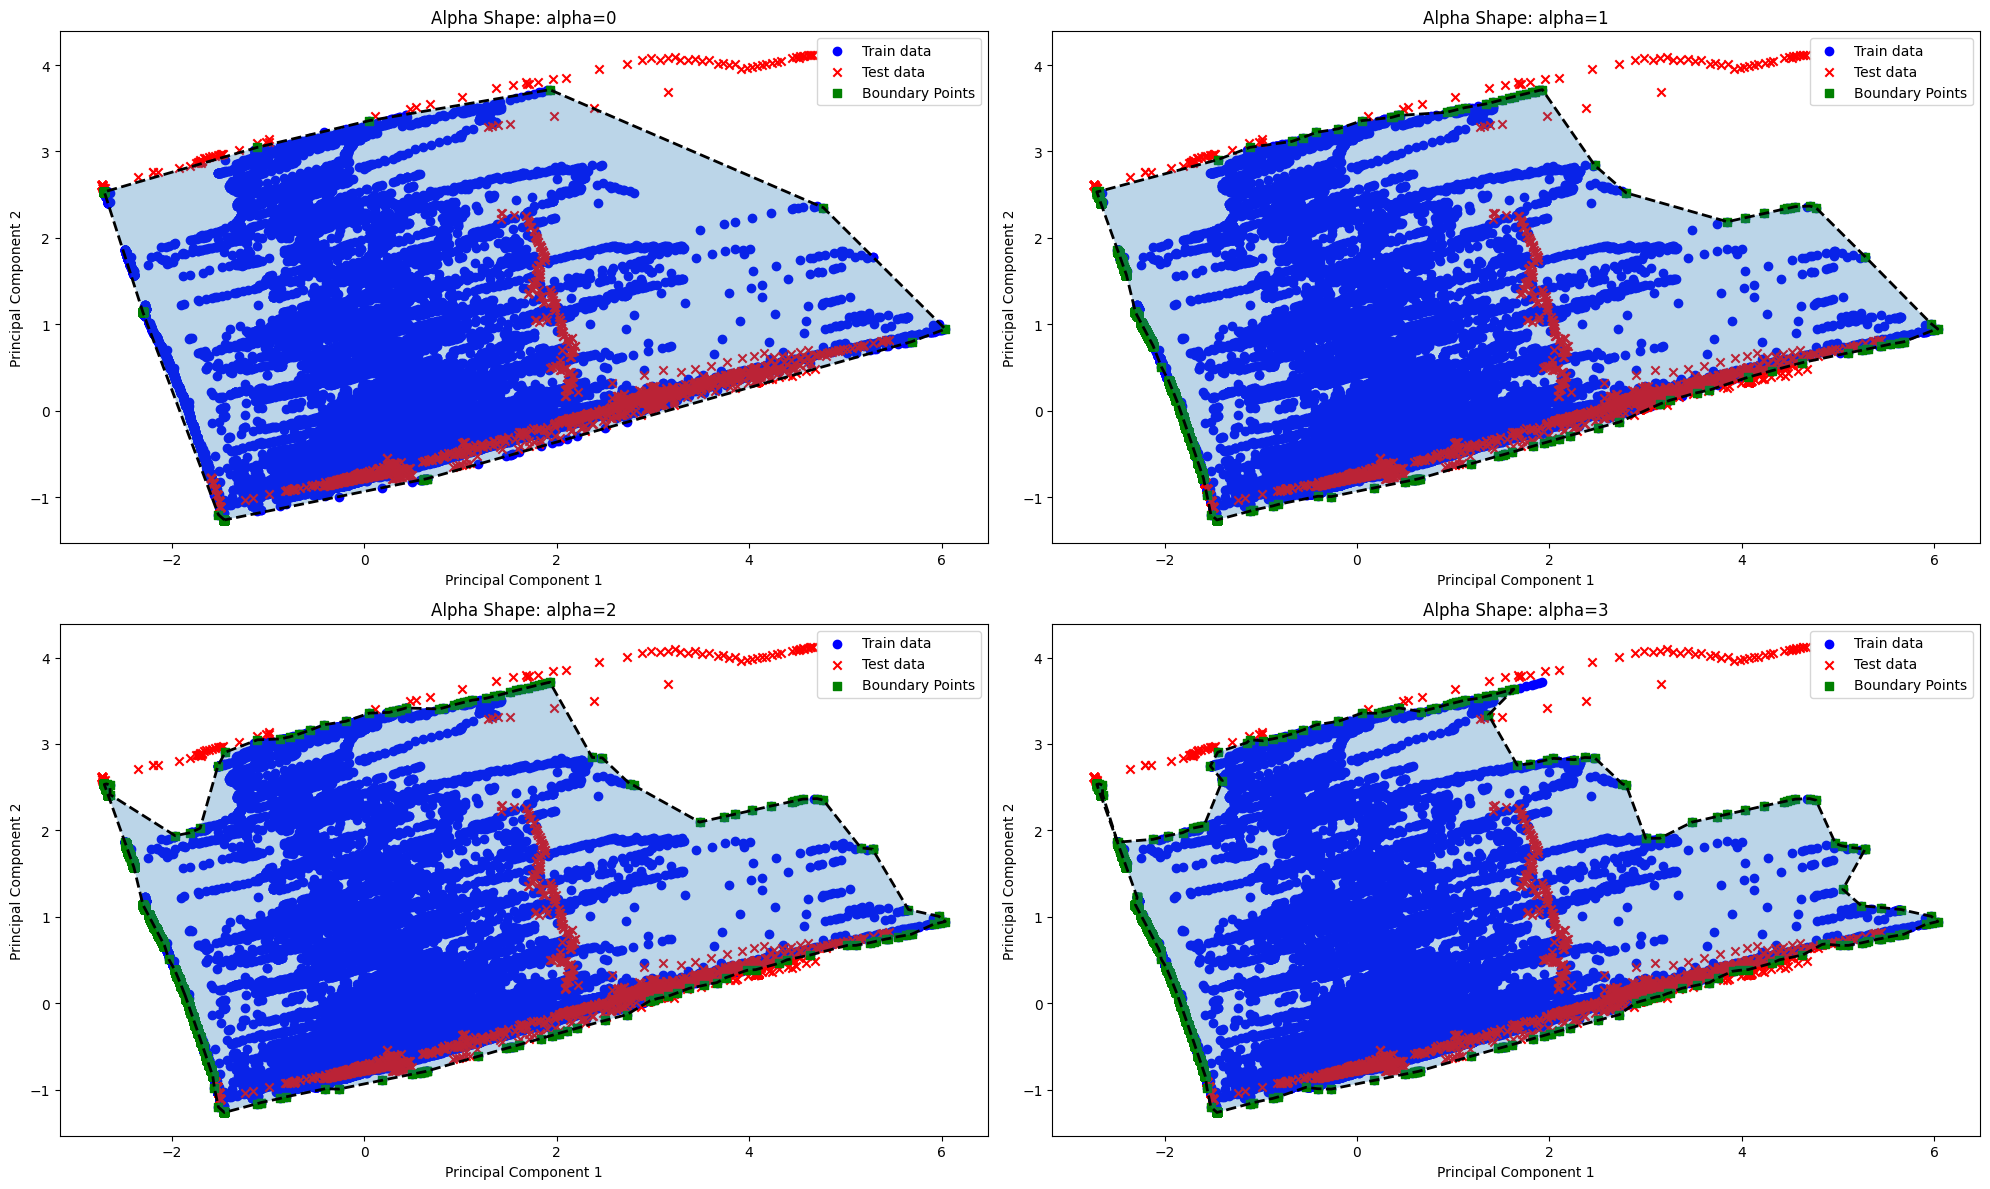

In [14]:
from shapely.geometry import MultiPoint, Point, shape
from alphashape import alphashape

def is_near_boundary(point, alpha_shape, threshold=1e-5):
    point = Point(point)
    return alpha_shape.boundary.distance(point) < threshold

# Initialize
outsider_test_points = {}
boundary_train_points = {}
original_boundary_train_points = {}
original_boundary_train_IDs = {}
original_outsider_test_points = {}
original_outsider_test_IDs = {}

fig, axes = plt.subplots(2, 2, figsize=(20, 12))

for i, alpha_value in enumerate(range(0, 4)):
    ax = axes[i//2, i%2]
    alpha_shape = alphashape(pca_train_data, alpha=alpha_value)
    
    # outside : alpha shape
    outsider_test_indices = [not alpha_shape.contains(Point(point)) for point in pca_test_data]
    outsider_test_points[alpha_value] = pca_test_data[np.where(outsider_test_indices)]
    
    # boundary : alpha shape
    boundary_train_indices = [is_near_boundary(point, alpha_shape) for point in pca_train_data]
    boundary_train_points[alpha_value] = pca_train_data[np.where(boundary_train_indices)]
    
    print(f"For alpha={alpha_value}, number of outsider_test_indices: {np.sum(outsider_test_indices)}")
    print(f"For alpha={alpha_value}, number of boundary_train_indices: {np.sum(boundary_train_indices)}")

    # 元の特徴空間でのデータ
    original_boundary_train_points[alpha_value] = train_data[selected_features].iloc[np.where(boundary_train_indices)[0]]
    original_boundary_train_IDs[alpha_value] = train_ID.iloc[np.where(boundary_train_indices)[0]]

    # 元の特徴空間でのデータ
    original_outsider_test_points[alpha_value] = test_data[selected_features].iloc[np.where(outsider_test_indices)[0]]
    original_outsider_test_IDs[alpha_value] = test_ID.iloc[np.where(outsider_test_indices)[0]]

    # Plotting
    ax.scatter(pca_train_data[:, 0], pca_train_data[:, 1], c='blue', marker='o', label='Train data')
    ax.scatter(pca_test_data[:, 0], pca_test_data[:, 1], c='red', marker='x', label='Test data')
    ax.scatter(boundary_train_points[alpha_value][:, 0], boundary_train_points[alpha_value][:, 1], c='green', marker='s', label='Boundary Points')
    #ax.scatter(outsider_test_points[alpha_value][:, 0], outsider_test_points[alpha_value][:, 1], c='purple', marker='^', label='Outsider Test Points')

    if alpha_shape.geom_type == 'Polygon':
        ax.plot(*alpha_shape.exterior.xy, c='k', linestyle='--', lw=2)
        ax.fill(*alpha_shape.exterior.xy, alpha=0.3)
    elif alpha_shape.geom_type == 'MultiPolygon':
        for shape in alpha_shape:
            ax.plot(*shape.exterior.xy, c='k', linestyle='--', lw=2)
            ax.fill(*shape.exterior.xy, alpha=0.3)

    ax.set_title(f'Alpha Shape: alpha={alpha_value}')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.legend()

plt.tight_layout()
plt.show()


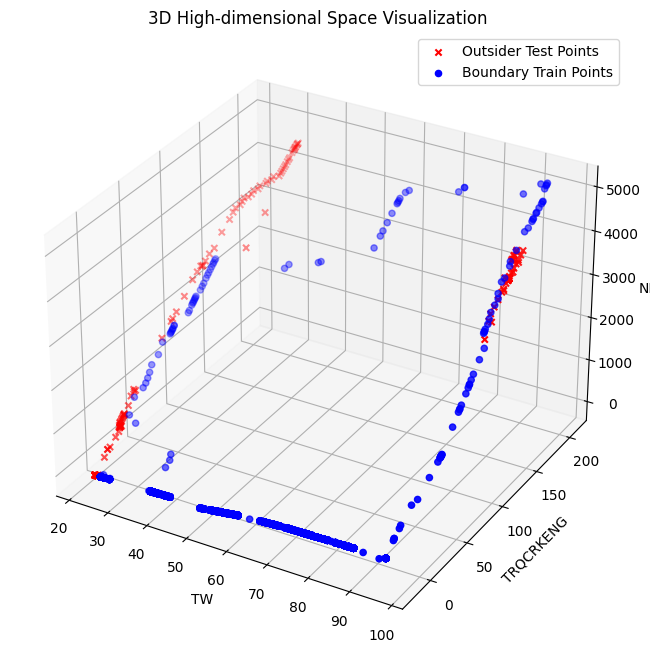

In [5]:
#choose alpha_value of alpha shape
alpha_mode=2
selected_outsider_test_points = outsider_test_points[alpha_mode]
selected_boundary_train_points = boundary_train_points[alpha_mode]

# PCAの逆変換
inv_pca_outsider_test = pca.inverse_transform(selected_outsider_test_points)
inv_scaler_outsider_test = scaler.inverse_transform(inv_pca_outsider_test) #標準化の逆変換=原始変数の状態に復元

inv_pca_boundary_train = pca.inverse_transform(selected_boundary_train_points)
inv_scaler_boundary_train = scaler.inverse_transform(inv_pca_boundary_train)

# feature names
feature_names = selected_features

# 3D Visualizing
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot:inverse test data 
ax.scatter(inv_scaler_outsider_test[:, 0], inv_scaler_outsider_test[:, 1], inv_scaler_outsider_test[:, 2], c='red', marker='x', label='Outsider Test Points')

# Plot:inverse train boundary points
ax.scatter(inv_scaler_boundary_train[:, 0], inv_scaler_boundary_train[:, 1], inv_scaler_boundary_train[:, 2], c='blue', marker='o', label='Boundary Train Points')

ax.set_title('3D High-dimensional Space Visualization')
ax.set_xlabel(feature_names[0])  
ax.set_ylabel(feature_names[1])
ax.set_zlabel(feature_names[2])
ax.legend()
plt.show()

# Export to HTML
df_outsider_test = pd.DataFrame(inv_scaler_outsider_test, columns=feature_names)
df_outsider_test['label'] = 'Outsider Test Points'

df_boundary_train = pd.DataFrame(inv_scaler_boundary_train, columns=feature_names)
df_boundary_train['label'] = 'Boundary Train Points'

# データフレーム結合
df_combined = pd.concat([df_outsider_test, df_boundary_train])

# 3D 散布図をプロット
fig = px.scatter_3d(df_combined, x=feature_names[0], y=feature_names[1], z=feature_names[2], color='label')
fig.write_html("invPCA_3D_Plot.html")


In [6]:
# train_data[selected_features]は原始変数(標準化はされてない)

# 3D Visualization in original high-dimensional space
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plotting all the original train data points
ax.scatter(train_data[selected_features].iloc[:, 0], train_data[selected_features].iloc[:, 1], train_data[selected_features].iloc[:, 2], c='green', marker='o', label='Train Data')

# Plotting all the original test data points
ax.scatter(test_data[selected_features].iloc[:, 0], test_data[selected_features].iloc[:, 1], test_data[selected_features].iloc[:, 2], c='red', marker='x', label='Test Data')

# Axis labels and title
ax.set_xlabel(selected_features[0])
ax.set_ylabel(selected_features[1])
ax.set_zlabel(selected_features[2])
ax.set_title('3D Plot of Original Data')
ax.legend()
plt.show()


# 元の訓練データとテストデータをデータフレームに変換
df_train_data = train_data[selected_features]
df_train_data['label'] = 'Train Data'

df_test_data = test_data[selected_features]
df_test_data['label'] = 'Test Data'

# データフレーム結合
df_combined = pd.concat([df_train_data, df_test_data])

# 3D export
fig = px.scatter_3d(df_combined, x=selected_features[0], y=selected_features[1], z=selected_features[2], color='label')
fig.write_html("Original_3D_Plot.html")


In [7]:
import plotly.graph_objects as go

# Calculating Convex Hull
points = train_data[selected_features].to_numpy()
hull = ConvexHull(points)

# Plotly figure
fig = go.Figure()

# Add scatter plot
fig.add_trace(go.Scatter3d(x=train_data[selected_features].iloc[:, 0],
                           y=train_data[selected_features].iloc[:, 1],
                           z=train_data[selected_features].iloc[:, 2],
                           mode='markers',
                           marker=dict(size=4, color='green'),
                           name='Train Data'))

fig.add_trace(go.Scatter3d(x=test_data[selected_features].iloc[:, 0],
                           y=test_data[selected_features].iloc[:, 1],
                           z=test_data[selected_features].iloc[:, 2],
                           mode='markers',
                           marker=dict(size=4, color='red'),
                           name='Test Data'))

# Add mesh for Convex Hull
fig.add_trace(go.Mesh3d(x=points[:, 0],
                         y=points[:, 1],
                         z=points[:, 2],
                         i=hull.simplices[:, 0],
                         j=hull.simplices[:, 1],
                         k=hull.simplices[:, 2],
                         opacity=0.5,
                         name='Convex Hull'))

# Set axis label
fig.update_layout(scene=dict(xaxis_title=selected_features[0],
                             yaxis_title=selected_features[1],
                             zaxis_title=selected_features[2]),
                  title='3D Plot of Original Data with Convex Hull')

# Save as HTML
fig.write_html("Original_3D_Plot_with_Convex_Hull.html")
fig.show()

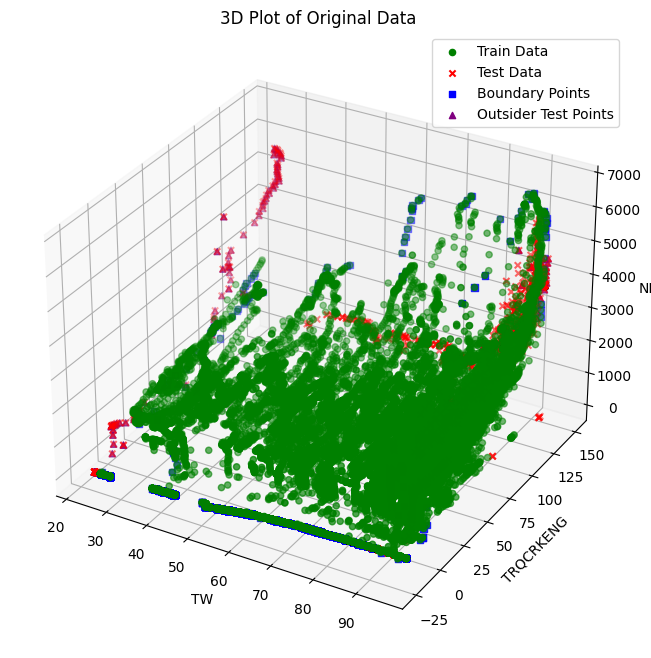

Number of original_boundary_train_points for alpha=3: 3498
Number of original_outsider_test_points for alpha=3: 649


In [15]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# 3D Visualization in original high-dimensional space
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plotting all the original train data points
ax.scatter(train_data[selected_features].iloc[:, 0], train_data[selected_features].iloc[:, 1], train_data[selected_features].iloc[:, 2], c='green', marker='o', label='Train Data')

# Plotting all the original test data points
ax.scatter(test_data[selected_features].iloc[:, 0], test_data[selected_features].iloc[:, 1], test_data[selected_features].iloc[:, 2], c='red', marker='x', label='Test Data')

# Plotting the original_boundary_train_points for a specific alpha_value (e.g., 0)
alpha_value = 3  # Change this to the alpha_value you're interested in
ax.scatter(original_boundary_train_points[alpha_value].iloc[:, 0], original_boundary_train_points[alpha_value].iloc[:, 1], original_boundary_train_points[alpha_value].iloc[:, 2], c='blue', marker='s', label='Boundary Points')

# Plotting the original_outsider_test_points for a specific alpha_value (e.g., 0)
ax.scatter(original_outsider_test_points[alpha_value].iloc[:, 0], original_outsider_test_points[alpha_value].iloc[:, 1], original_outsider_test_points[alpha_value].iloc[:, 2], c='purple', marker='^', label='Outsider Test Points')

# Axis labels and title
ax.set_xlabel(selected_features[0])
ax.set_ylabel(selected_features[1])
ax.set_zlabel(selected_features[2])
ax.set_title('3D Plot of Original Data')
ax.legend()
plt.show()


print(f"Number of original_boundary_train_points for alpha={alpha_value}: {len(original_boundary_train_points[alpha_value])}")
print(f"Number of original_outsider_test_points for alpha={alpha_value}: {len(original_outsider_test_points[alpha_value])}")

In [16]:
import plotly.graph_objects as go

# Plotly figure
fig = go.Figure()

# Add scatter plot for original train data points
fig.add_trace(go.Scatter3d(x=train_data[selected_features].iloc[:, 0],
                           y=train_data[selected_features].iloc[:, 1],
                           z=train_data[selected_features].iloc[:, 2],
                           mode='markers',
                           marker=dict(size=4, color='green'),
                           name='Train Data'))

# Add scatter plot for original test data points
fig.add_trace(go.Scatter3d(x=test_data[selected_features].iloc[:, 0],
                           y=test_data[selected_features].iloc[:, 1],
                           z=test_data[selected_features].iloc[:, 2],
                           mode='markers',
                           marker=dict(size=4, color='red'),
                           name='Test Data'))

# Add scatter plot for original_boundary_train_points
alpha_value = 3  # The alpha_value you're interested in
fig.add_trace(go.Scatter3d(x=original_boundary_train_points[alpha_value].iloc[:, 0],
                           y=original_boundary_train_points[alpha_value].iloc[:, 1],
                           z=original_boundary_train_points[alpha_value].iloc[:, 2],
                           mode='markers',
                           marker=dict(size=4, color='blue'),
                           name='Boundary Points'))

# Add scatter plot for original_outsider_test_points
fig.add_trace(go.Scatter3d(x=original_outsider_test_points[alpha_value].iloc[:, 0],
                           y=original_outsider_test_points[alpha_value].iloc[:, 1],
                           z=original_outsider_test_points[alpha_value].iloc[:, 2],
                           mode='markers',
                           marker=dict(size=4, color='purple'),
                           name='Outsider Test Points'))

# Set axis label
fig.update_layout(scene=dict(xaxis_title=selected_features[0],
                             yaxis_title=selected_features[1],
                             zaxis_title=selected_features[2]),
                  title=f'3D Plot of Original Data for alpha={alpha_value}')

# Save as HTML
fig.write_html(f"Original_3D_Plot_for_alpha_{alpha_value}.html")

# Show the figure
fig.show()
